In [1]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.exposure import equalize_adapthist


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import time

from sklearn.metrics import mean_squared_error

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error

import seaborn as sn
from PL import weight_derivation

In [31]:
class Landcover:
    
    def __init__(self, rasters_list):
        
        self.rasters = rasters_list
        self.model_input = None
        self.width = 0
        self.height = 0
        self.depth = 0
        self.no_of_ranges = None
        self.models = None
        self.predicted_rasters = None
        self.s_scores = []
        self.inertia_scores = []
        self.gt_kmeans = None
        self.X_scaled = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
         
        
    def set_raster_stack(self):
        #self.rasters = self.rasters.sort()
        l = []
        for i in self.rasters:
          with rio.open(i, 'r') as f:
            l.append(f.read(1))

        # Data
        arr_st = np.stack(l)
        print(arr_st.shape)
        self.depth, self.height, self.width = arr_st.shape
        x = np.moveaxis(arr_st, 0, -1)
        print(x.shape)
        #self.model_input = bands_stack.reshape(self.width * self.height, self.depth)
        self.model_input = x.reshape(-1, self.depth)
        print(self.model_input.shape)


    def get_ground_truth(self, name):
        gt_sanderban = np.genfromtxt(name, delimiter=',')
        gt_sanderban = gt_sanderban.flatten()
        self.gt_sanderban = gt_sanderban
        return self.gt_sanderban


    def preprocessing(self):
        
        scaler = StandardScaler().fit(self.model_input)
        

        X_scaled = scaler.transform(self.model_input)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, self.gt_sanderban, 
                                                    test_size=0.30, stratify = self.gt_sanderban, random_state=200)
        #X_scaled.shape, gt_sanderban.shape
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.X_scaled = X_scaled
        return self.X_scaled
                
          
    def classification(self, clf):
        start_time = time.time()
        clf.fit(self.X_train, self.y_train)

        # Predict the labels of test data

        #clf_pred = clf.predict(self.X_test)
        elapsed_time = time.time() - start_time
        print("La durée d'exécution est de : {}s".format(elapsed_time))
        
        #print(metrics.accuracy_score(self.y_test, clf_pred))
        
        
        predicted = clf.predict(self.X_scaled)
        
        acc = (metrics.accuracy_score(self.gt_kmeans, predicted))*100
        print("L'accuracy est de : {}".format(acc))
        
        print(classification_report(self.gt_kmeans, predicted))
        
        mse = mean_squared_error(self.gt_kmeans, predicted)
        rmse = np.sqrt(mse)
        print("RMSE: ", np.round(rmse, 2))
        
        kappa = cohen_kappa_score(self.gt_kmeans, predicted)
        print("La valeur de Kappa: {}".format(kappa))
        
        names = ['Class-1','Class-2', 'Class-3','Class-4','Class-5','Class-6']
        dataRF = confusion_matrix(self.gt_kmeans, predicted)
        df_cm = pd.DataFrame(dataRF, columns=np.unique(names), index = np.unique(names))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (10,8))
        sn.set(font_scale=1.4)#for label size
        sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
        plt.savefig('cmap-RF.png', dpi=300)
        
        
        print("Classification finale")
        ep.plot_bands(predicted.reshape((self.height, self.width)),   #self.height, self.width
                      cmap ='Accent')
        plt.show()
           
            

In [32]:
sanderband_bands = glob("Sandeband/*B?*.tiff")

In [33]:
sanderband_bands.sort()
sanderband_bands

['Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B12_(Raw).tiff',
 'Sandeband/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B8A_(Raw).tiff']

In [34]:
sanderband_set = Landcover(sanderband_bands)
sanderband_set.set_raster_stack()

(12, 954, 298)
(954, 298, 12)
(284292, 12)


In [35]:
gt_kmeans = sanderband_set.get_ground_truth("sanderban_GT.csv")

In [36]:
X_scaled = sanderband_set.preprocessing()

In [37]:
gt_kmeans.shape, X_scaled.shape

((284292,), (284292, 12))

# Partie classification

# logestic regression

In [38]:
# Initialisation de l'estimateur de régression logistique
log_reg = LogisticRegression(C=110.0, penalty='l2', solver='lbfgs', max_iter=300, random_state=200)

La durée d'exécution est de : 2.978633165359497s
L'accuracy est de : 99.79879841852744
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     53435
         1.0       1.00      1.00      1.00     55742
         2.0       1.00      1.00      1.00     76719
         3.0       0.99      0.99      0.99     37023
         4.0       1.00      1.00      1.00     20316
         5.0       1.00      1.00      1.00     41057

    accuracy                           1.00    284292
   macro avg       1.00      1.00      1.00    284292
weighted avg       1.00      1.00      1.00    284292

RMSE:  0.12
La valeur de Kappa: 0.9975174808282565
Classification finale


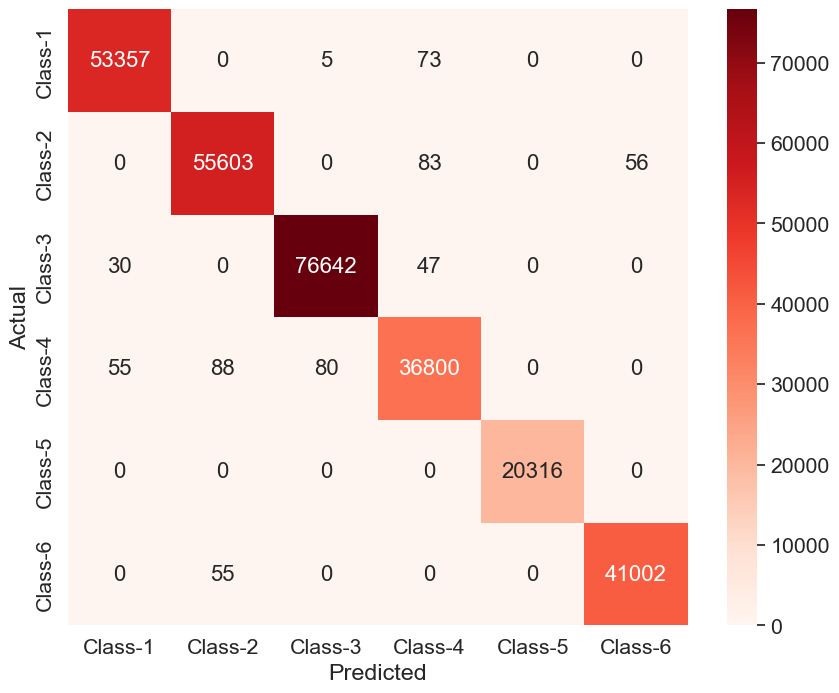

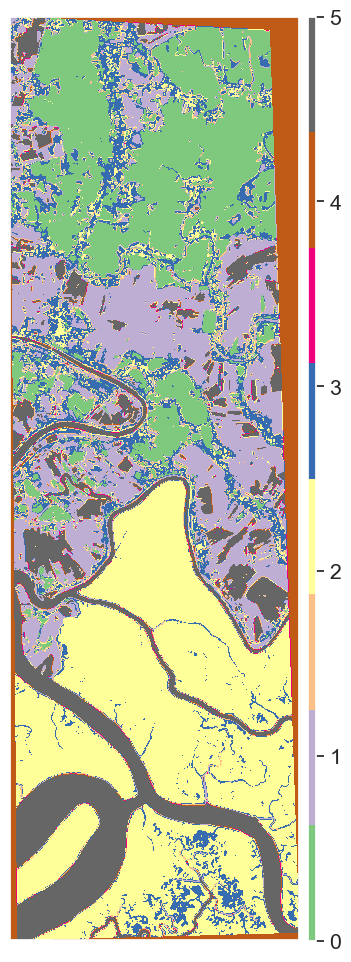

In [39]:
pred = sanderband_set.classification(log_reg)


# KNN

In [40]:
knn = KNeighborsClassifier(algorithm='kd_tree',metric='minkowski', n_neighbors = 20, weights = 'distance')

La durée d'exécution est de : 0.12536907196044922s
L'accuracy est de : 99.65704275885358
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     53435
         1.0       1.00      1.00      1.00     55742
         2.0       1.00      1.00      1.00     76719
         3.0       0.99      0.99      0.99     37023
         4.0       1.00      1.00      1.00     20316
         5.0       1.00      1.00      1.00     41057

    accuracy                           1.00    284292
   macro avg       1.00      1.00      1.00    284292
weighted avg       1.00      1.00      1.00    284292

RMSE:  0.15
La valeur de Kappa: 0.9957683220382858
Classification finale


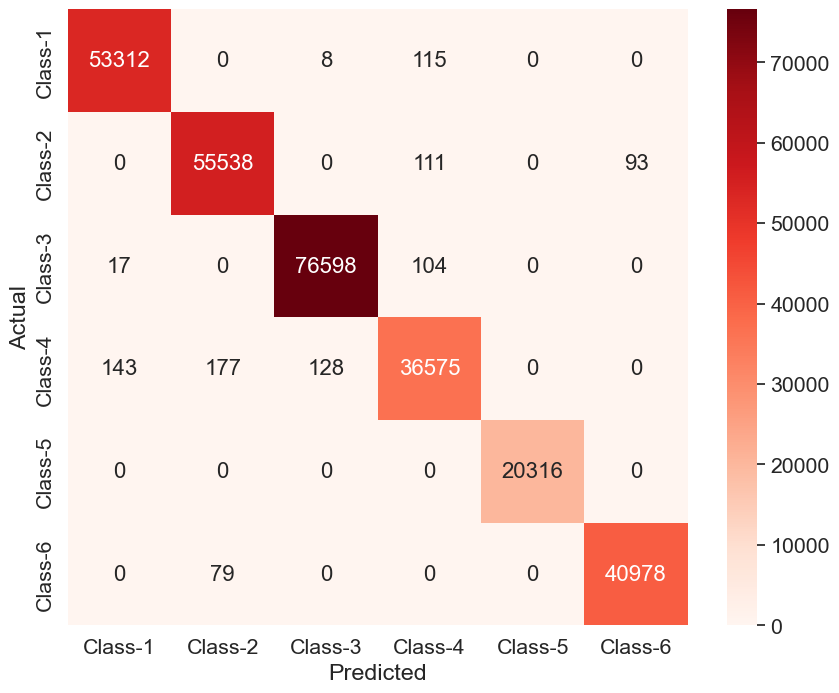

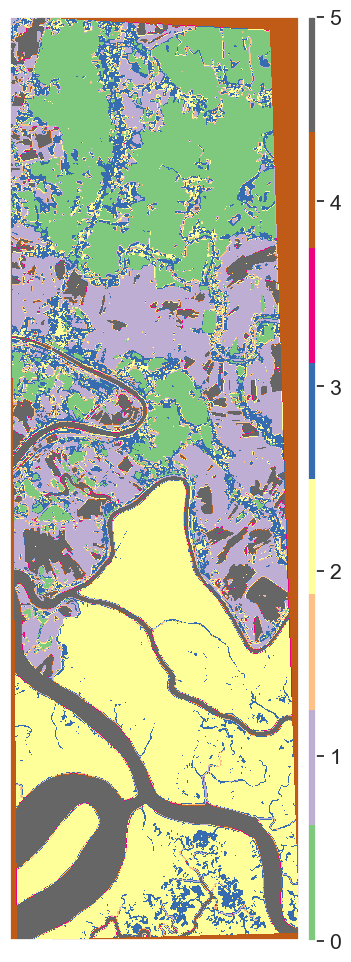

In [41]:
sanderband_set.classification(knn)

# SVM

In [42]:
SVM = SVC(C = 20, kernel = 'rbf', cache_size = 10*1024, random_state=200)#, cache_size = 10*1024

La durée d'exécution est de : 8.354984998703003s
L'accuracy est de : 99.91804201314142
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     53435
         1.0       1.00      1.00      1.00     55742
         2.0       1.00      1.00      1.00     76719
         3.0       1.00      1.00      1.00     37023
         4.0       1.00      1.00      1.00     20316
         5.0       1.00      1.00      1.00     41057

    accuracy                           1.00    284292
   macro avg       1.00      1.00      1.00    284292
weighted avg       1.00      1.00      1.00    284292

RMSE:  0.08
La valeur de Kappa: 0.9989887730337809
Classification finale


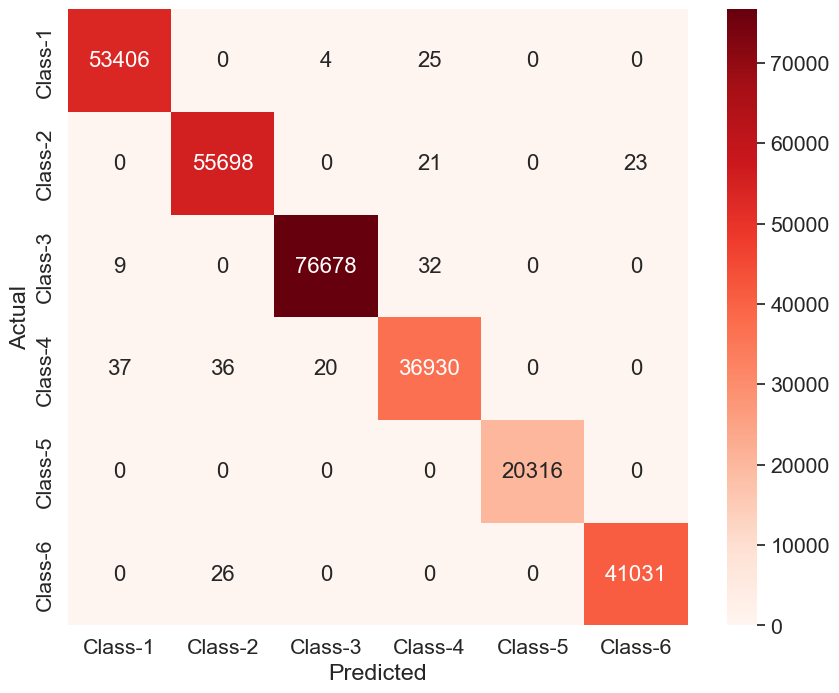

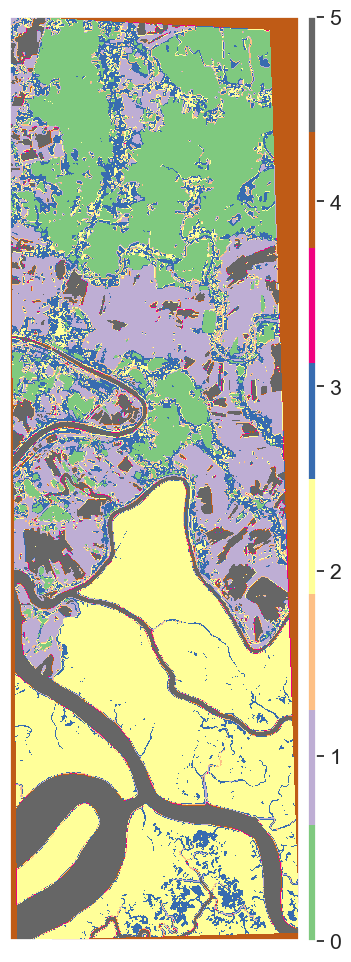

In [43]:
sanderband_set.classification(SVM)

# RF

In [44]:
RF = RandomForestClassifier(max_depth = 5,n_estimators = 20,max_features = 1, random_state=200)

La durée d'exécution est de : 1.1184029579162598s
L'accuracy est de : 96.14093959731544
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     53435
         1.0       0.93      0.96      0.94     55742
         2.0       0.98      0.98      0.98     76719
         3.0       0.90      0.88      0.89     37023
         4.0       1.00      1.00      1.00     20316
         5.0       0.98      0.96      0.97     41057

    accuracy                           0.96    284292
   macro avg       0.96      0.96      0.96    284292
weighted avg       0.96      0.96      0.96    284292

RMSE:  0.52
La valeur de Kappa: 0.9523693804473209
Classification finale


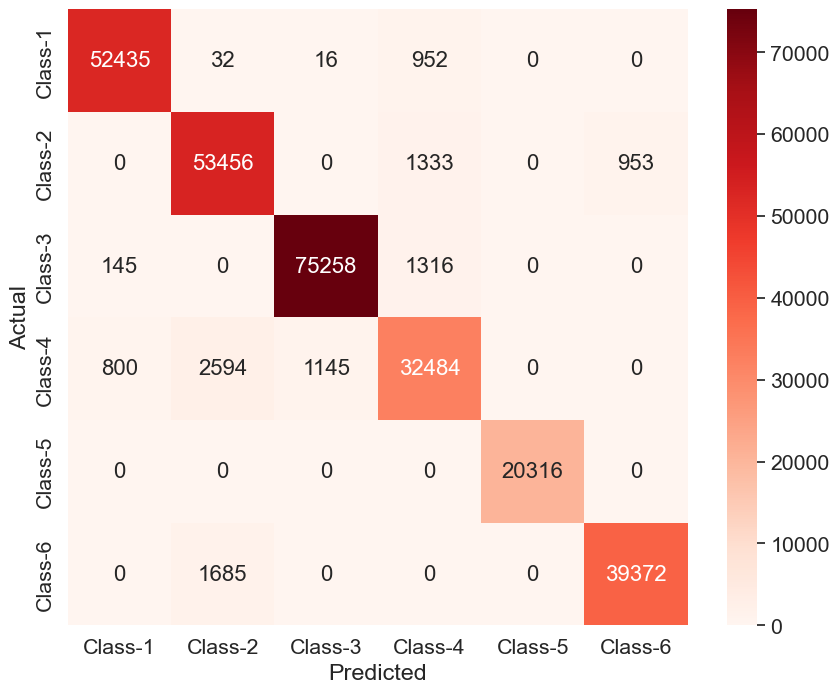

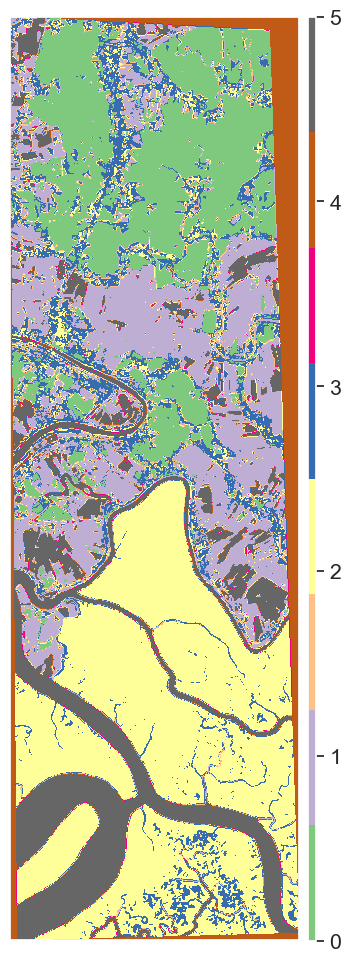

In [45]:
sanderband_set.classification(RF)

In [46]:
A = np.array([[1, 2, 3],  
              [1/2, 1, 2], 
              [1/3, 1/2, 1]])

In [47]:
weight_derivation(A)

Beta = 3.0833333333333335
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/tchouar/Downloads/tr/pfeve/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/87/c96z3lj528s0yqr3y568z9qr0000gn/T/8593e9a68dc2475890534864fd27512a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/87/c96z3lj528s0yqr3y568z9qr0000gn/T/8593e9a68dc2475890534864fd27512a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 58 RHS
At line 69 BOUNDS
At line 76 ENDATA
Problem MODEL has 10 rows, 6 columns and 27 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.331683 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
To

# Ensemble learning


In [48]:
eclf = VotingClassifier(estimators=[('LR', log_reg), ('RF', RF), ('KNN', knn)],
                        voting='soft', weights=[0.5396, 0.1633, 0.2970])

La durée d'exécution est de : 4.663559913635254s
L'accuracy est de : 99.91065524179365
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     53435
         1.0       1.00      1.00      1.00     55742
         2.0       1.00      1.00      1.00     76719
         3.0       1.00      1.00      1.00     37023
         4.0       1.00      1.00      1.00     20316
         5.0       1.00      1.00      1.00     41057

    accuracy                           1.00    284292
   macro avg       1.00      1.00      1.00    284292
weighted avg       1.00      1.00      1.00    284292

RMSE:  0.08
La valeur de Kappa: 0.9988976176271994
Classification finale


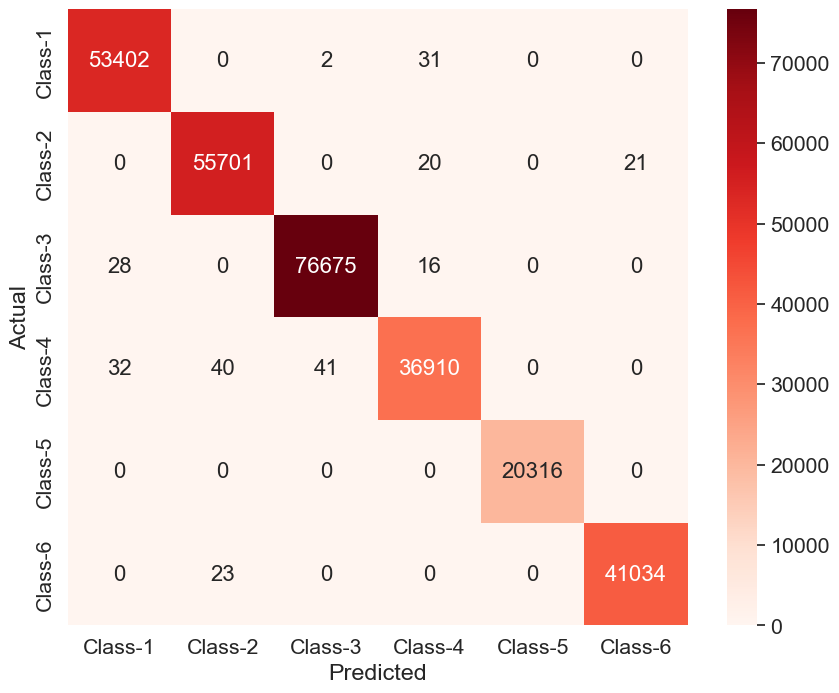

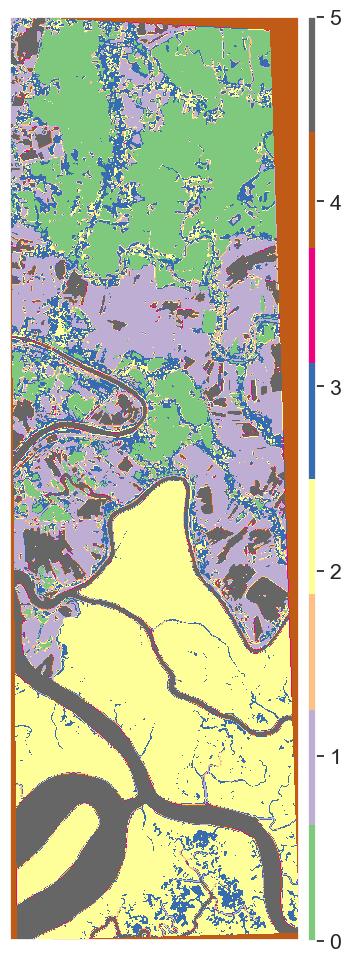

In [49]:
sanderband_set.classification(eclf)